In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import scipy.stats as ss
import csv
import numpy as np
import sklearn
import glob
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from tfg_tools import *

C:\Users\ywen2\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Para que sea más sencillo nombrar las variables, vamos a definir dos modelos:
- **Modelo 1**: eliminamos las variables Blood Glucose y Glycated-HB
- **Modelo 2**: eliminamos también Vitamin-D, HOMA, Insulin

# 1. PREPROCESADO:

- **Cargamos las matrices anteriormente creadas** y que fueron divididas en train y test. Cargamos tanto los pacientes con sus variables y revisiones como las etiquetas asociadas a cada paciente

In [2]:
X_train = np.load('Conjunto_train.npy')
X_test = np.load('Conjunto_test.npy')
y_train = np.load('Labels_train.npy')
y_test = np.load('Labels_test.npy')

- **Comprobamos las dimensiones de cada matriz**, tenemos 1317 pacientes para train y 330 para test (partición 80/20).

- El 13 hace referencia al número de revisiones que nosotros mismos decicimos como idóneas. 
- 22 son el número de features.

In [3]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(1317,)
(1317, 13, 22)
(330,)
(330, 13, 22)


Comenzamos trabajando con la primera revisión.

- X_train_1[:,0,:] hace referencia al primer instante temporal (1º revisión), cogemos todos los pacientes y todas las features para ese primer instante.

In [4]:
X_train_1 = X_train[:,0,:]

Solo utilizaremos esta variable (X_train_1) para obtener el nombre de las features.

### Desbalanceo de clases

- Como observamos el el histograma, los **datos están desbalanceados**.

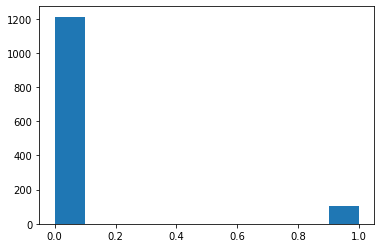

In [5]:
plt.hist(y_train)
plt.show()

### Pasos previos

Antes de construir el modelo, debemos:


1. Revisar si hay alguna característica que tenga más del 50% a NaN, entonces habría que considerar eliminarla. Tenemos un problema, porque hay que revisar que tengo más de 50% en todas las revisiones. Para no complicar las cosas, vamos a considerar que trabajamos sólo con tres revisiones (vamos a ver si llegamos rápido a ese punto, en otro caso deberíamos ver si paramos en tres revisiones, que ya es bastante).

2. Revisar si hay algún paciente con más de 8 características NaN, con que esto ocurra en cualquiera de las tres revisiones, deberíamos considerarlo que se elimina, en todas las revisiones.

### 1.1 Features con problemas:

Revisando la información rápidamente hay varias features con problemas:

1. **Importante**: las variables *Blood_Glucose* y *Glycated-HB* hay que sacarlas fuera de la base de datos, porque son las que se utilizan para determinar si un pacientes diabético o no.
1. Hay cuatro variables que tiene muchos NaN, así que lo que intentaría sería centrarnos en cómo imputarlas, tanto en training como en test. Esto es un poco más complicado de lo que hacemos habitualmente con las bases de datos normales, porque aquí tenemos más datos y de forma un poco más complicada.
    * HOMA
    * Insulin
    * Vitamin-D
   
Estas son las que más tienen en las tres primeras revisiones. Lo que vamos a hacer es lo siguiente, aprovechando que tenemos un montón de datos y datos temporales vamos a utilizar un esquema diferente para hacer la imputación de forma que sea más razonable, intentando perder el menor número de datos posibles, por ejemplo: 
 * Regresión lineal múltiple con respecto a todas las variables temporales. Otra cosa
 * Verificar cuál es la correlación entre variables, para una misma revisión, y buscar con las que mayor correlación tengan y proponer un modelo de regresión lineal. 
 
Mi propuesta para el TFG: 
 * Vamos a hacer imputación por la mediana (en el caso de Vitamin-D, HOMA e Insulin) casi seguro que vamos a empeorar un poco porque hay muchos NaN, pero la esperanza es que todo se compense.
 * Si te ves con fuerzas y ganas probamos lo que he comentado anteriormente



In [6]:
feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']
    
df = pd.DataFrame(X_train_1,columns = feature_names[:-1])

### Cantidad de NaN para cada variable en la primera revisión.

In [7]:
for index,value in enumerate (df.isnull().sum()):
        if value !=0:
            print(df.columns[index],value)

Weight 15
Size 6
IMC 19
Creatinine 21
Cystatin 263
HDL 115
LDL 135
Triglyciredes 24
GOT 198
GPT 26
GGT 54
Albuminuria 209
Ferritin 133
HOMA 958
Insulin 939
Blood_Glucose 27
Glycated-HB 740
PCR 231
Vitamin-D 1079


In [8]:
for index,value in enumerate (df.isnull().sum()):
        if value !=0:
            print(df.columns[index],value/len(df)*100)

1.1389521640091116
0.45558086560364464
1.442672741078208
1.5945330296127564
19.96962794229309
8.731966590736523
10.250569476082005
1.8223234624145785
15.034168564920272
1.9741837509491267
4.100227790432802
15.869400151860289
10.098709187547456
72.74107820804859
71.29840546697038
2.050113895216401
56.18830675778283
17.539863325740317
81.92862566438876


### Imputamos la mediana por los NaN.

Creamos una nueva variable: **X_train_imp**, obtenida de aplicar la función imputing_data a X_train. Devuelve lo siguiente

- Nº de revisión
- Features
- Features con sus respectivos NaN (no aparecen las features eliminadas previamente por la función)

In [9]:
X_train_sin_NaN_modelo1_imputing, imputation_data = imputing_data(X_train)

review 0
review 1
review 2


Valores de **mediana** que se van a imputar por cada variable en las tres primeras revisiones.

In [10]:
imputation_data

[Age               60.00
 Weight            78.00
 Size             162.00
 IMC               29.40
 Creatinine         0.90
 Cystatin           0.83
 HDL               55.00
 LDL              105.00
 Triglyciredes    107.00
 GOT               21.00
 GPT               22.00
 GGT               23.00
 Albuminuria        6.29
 Ferritin         117.00
 HOMA               3.00
 Insulin           12.00
 PCR                3.19
 Vitamin-D         27.00
 TAS              139.00
 TAD               80.00
 dtype: float64, Age               60.00
 Weight            78.00
 Size             162.00
 IMC               29.30
 Creatinine         0.90
 Cystatin           0.84
 HDL               55.00
 LDL              103.00
 Triglyciredes    106.00
 GOT               20.00
 GPT               22.00
 GGT               22.50
 Albuminuria        5.36
 Ferritin         116.50
 HOMA               2.76
 Insulin           11.30
 PCR                3.27
 Vitamin-D         28.00
 TAS              139.00
 TAD     

### Obtenemos los datos para la primera revisión.

In [11]:
X_train_imputed = X_train_sin_NaN_modelo1_imputing[0]

print(X_train_imputed)

       Age  Weight   Size   IMC  Creatinine  Cystatin   HDL    LDL  \
0     79.0    99.0  157.0  40.2         1.1      1.37  36.0   59.0   
1     58.0   113.0  190.0  31.3         0.9      0.64  45.0  150.0   
2     53.0    51.0  143.0  24.9         0.5      0.69  78.0   95.0   
3     51.0    76.0  177.0  24.3         1.0      0.81  54.0  123.0   
4     46.0    40.0  155.0  16.6         1.0      1.25  61.0   62.0   
...    ...     ...    ...   ...         ...       ...   ...    ...   
1312  45.0    95.0  169.0  33.3         0.9      0.83  55.0  105.0   
1313  84.0    74.0  160.0  28.9         0.8      1.01  49.0   68.0   
1314  48.0    78.0  169.0  27.3         0.8      0.80  79.0  114.0   
1315  60.0    65.0  172.0  22.0         1.2      1.21  54.0  183.0   
1316  72.0    48.0  149.0  21.6         0.7      0.61  65.0  143.0   

      Triglyciredes   GOT   GPT    GGT  Albuminuria  Ferritin  HOMA  Insulin  \
0             167.0  18.0  19.0   38.0       129.66      30.0  3.00     12.0   

## Balanceo de clases
### Undersampling:

Las técnicas de *undersampling* eliminan ejemplos del conjunto de datos de entrenamiento que pertenecen a la clase mayoritaria para equilibrar mejor la distribución de clases.

La técnica de submuestreo más simple implica la selección aleatoria de ejemplos de la clase mayoritaria y su eliminación del conjunto de datos de entrenamiento. Esto se conoce como submuestreo aleatorio. Aunque simple y eficaz, una limitación de esta técnica es que los ejemplos se eliminan sin preocuparse por su utilidad o importancia para determinar el límite de decisión entre las clases. Esto significa que es posible, o incluso probable, que se elimine información útil.

Una extensión de este enfoque es ser más exigente con respecto a los ejemplos de la clase mayoritaria que se eliminan. Por lo general, se trata de modelos heurísticos o de aprendizaje que intentan identificar ejemplos redundantes para la eliminación o ejemplos útiles para la no eliminación

# 2. PREDICCIÓN

### 2.1 Random Forest

Debemos probar una amplia gama de valores y ver qué funciona. Intentaremos ajustar el siguiente conjunto de hiperparámetros:

- max_features = max number of features considered for splitting a node
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node

In [12]:
from sklearn.model_selection import RandomizedSearchCV
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,8,10,12,14,16,18,20]
# Create the random grid
random_grid = {'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
print(random_grid)

{'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8, 10, 12, 14, 16, 18, 20]}


En cada iteración, el algoritmo elegirá una combinación diferente de las características. El beneficio de una búsqueda aleatoria es que no probamos todas las combinaciones, sino que seleccionamos al azar para muestrear una amplia gama de valores.

**Grid Search**

GridSearchCV es una clase disponible en scikit-learn que permite evaluar y seleccionar de forma sistemática los parámetros de un modelo. Indicándole un modelo y los parámetros a probar, puede evaluar el rendimiento del primero en función de los segundos mediante validación cruzada.

- CV, que es el número de pliegues que se deben usar para la validación cruzada. 

- Más pliegues de cv reducen las posibilidades de sobreajuste, pero aumentarlo aumentará el tiempo de ejecución.

**Balanced Random Forest** es una modificación de RF, donde por cada árbol se construyen dos conjuntos bootstrap del mismo tamaño, igual al tamaño de la clase minoritaria: uno para la clase minoritaria, el otro para la clase mayoritaria. Conjuntamente, estos dos conjuntos constituyen el conjunto de entrenamiento.

In [13]:
# First create the base model to tune

#Creo que es mejor la estrategia que se presenta en from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

rf_1 = BalancedRandomForestClassifier(n_estimators=50, criterion='gini',  
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

In [14]:
from sklearn.model_selection import GridSearchCV
# Use the random grid to search for best hyperparameters
# Grid search of parameters, using 7 fold cross validation,

grid_random = GridSearchCV(rf_1, random_grid, cv=7 , n_jobs = -1, verbose = 5)

In [15]:
# Fit the random search model
grid_random.fit(X_train_imputed, y_train)

Fitting 7 folds for each of 90 candidates, totalling 630 fits


GridSearchCV(cv=7,
             estimator=BalancedRandomForestClassifier(class_weight='balanced_subsample',
                                                      n_estimators=50),
             n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 8, 10, 12, 14, 16, 18,
                                              20],
                         'min_samples_split': [2, 5, 10]},
             verbose=5)

In [16]:
grid_random.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}

Creamos un **nuevo modelo** teniendo en cuenta los hiperparámetros que nos devuelve Grid_Search

In [17]:
rf_2 = BalancedRandomForestClassifier(n_estimators=1000, criterion='gini', max_features = grid_random.best_params_['max_features'],
                min_samples_leaf = grid_random.best_params_['min_samples_leaf'], min_samples_split = grid_random.best_params_['min_samples_split'],    
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

In [18]:
rf_2.fit(X_train_imputed, y_train)

BalancedRandomForestClassifier(class_weight='balanced_subsample',
                               max_features='sqrt', n_estimators=1000)

In [19]:
y_pred_modelo1 = rf_2.predict(X_train_imputed)
print(y_pred_modelo1)

[0 1 0 ... 1 0 0]


In [20]:
y_pred_prob_modelo1 = rf_2.predict_proba(X_train_imputed)
print(y_pred_prob_modelo1)

[[0.729 0.271]
 [0.107 0.893]
 [0.512 0.488]
 ...
 [0.49  0.51 ]
 [0.564 0.436]
 [0.578 0.422]]


## 2.2 Prestaciones

La **sensibilidad y la especificidad** son dos valores que nos indican la capacidad de nuestro estimador para discriminar los casos positivos, de los negativos. La sensibilidad es la fracción de verdaderos positivos, mientras que la especificidad, es la fracción de verdaderos negativos.

-  **La sensibilidad** es la proporción de casos positivos que fueron correctamente identificadas por el algoritmo.
-  **La especificidad** se trata de los casos negativos que el algoritmo ha clasificado correctamente.  Expresa cuan bien puede el modelo detectar esa clase.
- **La Precisión** se refiere a la dispersión del conjunto de valores obtenidos a partir de mediciones repetidas de una magnitud. Cuanto menor es la dispersión mayor la precisión. Se representa por la proporción entre el número de predicciones correctas (tanto positivas como negativas) y el total de predicciones. En forma práctica es  el porcentaje de casos positivos detectados.


### Prestaciones en train

In [21]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

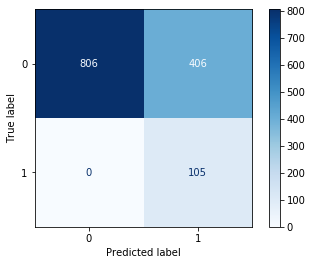

{0,0} True negatives
------
{1,0} False negatives
------
{1,1} True positives
------
{0,1} False positives
------
Accuracy :  0.6917236142748672
Sensitivity :  1.0
Specificity :  0.665016501650165
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.67      1.00      0.80      0.82      0.64      1212
          1       0.21      1.00      0.67      0.34      0.82      0.69       105

avg / total       0.94      0.69      0.97      0.76      0.82      0.65      1317



In [22]:
cm = confusion_matrix(y_train,y_pred_modelo1)

plot_confusion_matrix(rf_2,X_train_imputed,y_train,cmap=plt.cm.Blues)

plt.show()

print('{0,0} True negatives')
print('------')
print('{1,0} False negatives')
print('------')
print('{1,1} True positives')
print('------')
print('{0,1} False positives')
print('------')


accuracy1=(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,1]+cm[1,0])
print ('Accuracy : ', accuracy1)

sensitivity1 = cm[1,1]/(cm[1,0]+cm[1,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm[0,0]/(cm[0,0]+cm[0,1])  #ojo, creo que está al revés esto
print('Specificity : ', specificity1)

from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_train, y_pred_modelo1))

### Prestaciones en test

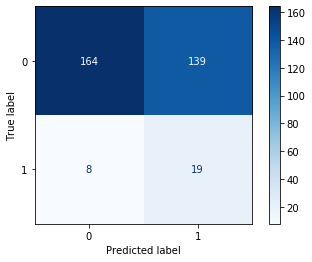

In [24]:
#modify NaNs in X_test

feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']

X_test_modelo1 = pd.DataFrame(X_test[:,0,:],columns = feature_names[:-1])

X_test_modelo1 = X_test_modelo1.drop('Blood_Glucose',axis = 1)
X_test_modelo1 = X_test_modelo1.drop('Glycated-HB',axis = 1)

#impute

X_test_modelo1 = X_test_modelo1.fillna(imputation_data[0])

y_pred_test_modelo1 = rf_2.predict(X_test_modelo1)
y_pred_test_prob_modelo1 = rf_2.predict_proba(X_test_modelo1)

plot_confusion_matrix(rf_2,X_test_modelo1,y_test,cmap=plt.cm.Blues)

plt.show()

In [25]:
cm1 = confusion_matrix(y_test,y_pred_test_modelo1)


print('{0,0} True negatives')
print('------')
print('{1,0} False negatives')
print('------')
print('{1,1} True positives')
print('------')
print('{0,1} False positives')
print('------')

accuracy1=(cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0]) 
print ('Accuracy : ', accuracy1)

specificity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Specificity : ', specificity1 )

sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Sensitivity : ', sensitivity1)

{0,0} True negatives
------
{1,0} False negatives
------
{1,1} True positives
------
{0,1} False positives
------
Accuracy :  0.5545454545454546
Specificity :  0.5412541254125413
Sensitivity :  0.7037037037037037


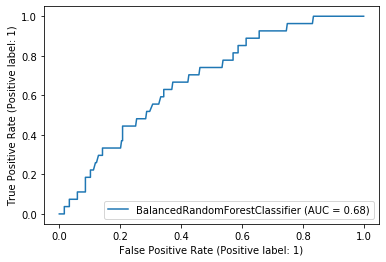

In [28]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(rf_2, X_test_modelo1,y_test)
plt.show()

## 2.3 Calibración de la probabilidad

In [40]:
from sklearn.calibration import CalibratedClassifierCV

base_clf = BalancedRandomForestClassifier(n_estimators=50, criterion='gini', max_features = grid_random.best_params_['max_features'],
                min_samples_leaf = grid_random.best_params_['min_samples_leaf'], min_samples_split = grid_random.best_params_['min_samples_split'],    
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

#vamos a calibrar training
calibrated_clf = CalibratedClassifierCV(base_estimator=rf_2,cv='prefit', method = 'isotonic',ensemble = False)

calibrated_clf.fit(X_train_imputed, y_train)

CalibratedClassifierCV(base_estimator=BalancedRandomForestClassifier(class_weight='balanced_subsample',
                                                                     max_features='sqrt',
                                                                     n_estimators=1000),
                       cv='prefit', ensemble=False, method='isotonic')

(array([324.,   0.,   1.,   1.,   0.,   1.,   2.,   0.,   0.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 1 Patch objects>)

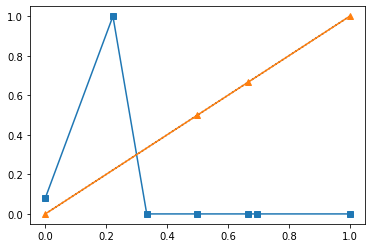

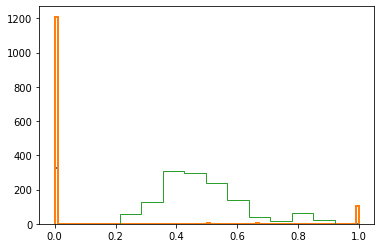

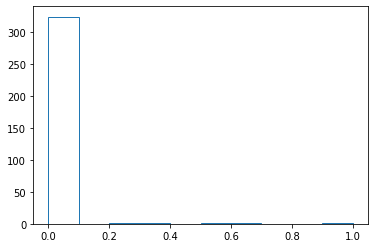

In [41]:
#calibrated_clf.
from sklearn.calibration import calibration_curve

feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']

X_test_1 = pd.DataFrame(X_test[:,0,:],columns = feature_names[:-1])

X_test_1 = X_test_1.drop('Blood_Glucose',axis = 1)
X_test_1 = X_test_1.drop('Glycated-HB',axis = 1)
#X_test_1 = X_test_1.drop('HOMA',axis = 1)
#X_test_1 = X_test_1.drop('Insulin',axis = 1)
#X_test_1 = X_test_1.drop('Vitamin-D',axis = 1)

X_test_1 = X_test_1.fillna(imputation_data[0])


y_pred_cali = calibrated_clf.predict_proba(X_test_1)[:,1]

y_train_cali = calibrated_clf.predict_proba(X_train_imputed)[:,1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_cali, n_bins=100)
fraction_of_positives_train, mean_predicted_value_train = calibration_curve(y_train, y_train_cali, n_bins=100)

plt.figure()
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot(mean_predicted_value_train, fraction_of_positives_train, "^-")


plt.figure()
plt.hist(y_pred_cali, range=(0, 1), bins=100,histtype="step", lw=2)
plt.hist(y_train_cali, range=(0, 1), bins=100,histtype="step", lw=2)


plt.hist(rf_2.predict_proba(X_train_imputed)[:,1],bins = 10,histtype='step')

plt.figure()
plt.hist(y_pred_cali,bins = 10,histtype='step')

# Aplicamos el modelo eliminando las variables Vitamin-D, HOMA e Insulin

# 1. PREPROCESADO

In [30]:
X_train_sin_NaN_modelo2_imputing,imputation_data_no_homa = imputing_data(X_train,without_homa_vit_d = True)

review 0
review 1
review 2


In [31]:
#Get the first reviews

X_train_imputed_no_homa = X_train_sin_NaN_modelo2_imputing[0]

print(X_train_imputed_no_homa.shape)

(1317, 17)


# 2. PREDICCIÓN

## 2.1 Random Forest

In [32]:
from sklearn.model_selection import RandomizedSearchCV
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,8,10,12,14,16,18,20]
# Create the random grid
random_grid = {'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
print(random_grid)

{'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8, 10, 12, 14, 16, 18, 20]}


In [33]:
# First create the base model to tune
rf_11 = BalancedRandomForestClassifier(n_estimators=50, criterion='gini',  
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

In [34]:
from sklearn.model_selection import GridSearchCV
# Use the random grid to search for best hyperparameters
# Grid search of parameters, using 7 fold cross validation,

grid_random = GridSearchCV(rf_11, random_grid, cv=7 , n_jobs = -1, verbose = 5)

In [35]:
# Fit the random search model
grid_random.fit(X_train_imputed_no_homa, y_train)

Fitting 7 folds for each of 90 candidates, totalling 630 fits


GridSearchCV(cv=7,
             estimator=BalancedRandomForestClassifier(class_weight='balanced_subsample',
                                                      n_estimators=50),
             n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 8, 10, 12, 14, 16, 18,
                                              20],
                         'min_samples_split': [2, 5, 10]},
             verbose=5)

In [36]:
grid_random.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}

### Rebalancea dentro de cada árbol

**BalancedRandomForestClassifier** is another ensemble method in which each tree of the forest will be provided a balanced bootstrap sample

In [37]:
rf_22 = BalancedRandomForestClassifier(n_estimators=1000, criterion='gini', max_features = grid_random.best_params_['max_features'],
                min_samples_leaf = grid_random.best_params_['min_samples_leaf'], min_samples_split = grid_random.best_params_['min_samples_split'],    
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

In [38]:
rf_22.fit(X_train_imputed_no_homa, y_train)

BalancedRandomForestClassifier(class_weight='balanced_subsample',
                               max_features='sqrt', min_samples_split=10,
                               n_estimators=1000)

In [39]:
y_pred_modelo2 = rf_22.predict(X_train_imputed_no_homa)
y_pred_1_prob_modelo2= rf_22.predict_proba(X_train_imputed_no_homa)
print(y_pred_modelo2)
print(y_pred_1_prob_modelo2)

[0 1 0 ... 0 0 0]
[[0.68791171 0.31208829]
 [0.1841731  0.8158269 ]
 [0.51513889 0.48486111]
 ...
 [0.50537212 0.49462788]
 [0.53228383 0.46771617]
 [0.51151488 0.48848512]]


## 2.3 Prestaciones

### Prestaciones en train

In [42]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

[[792 420]
 [  0 105]]


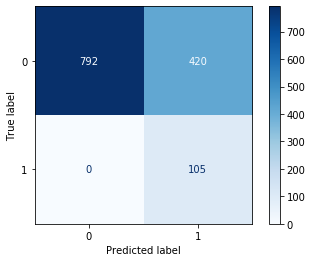

{0,0} True negatives
------
{1,0} False negatives
------
{1,1} True positives
------
{0,1} False positives
------
Accuracy :  0.6810933940774487
Sensitivity :  1.0
Specificity :  0.6534653465346535


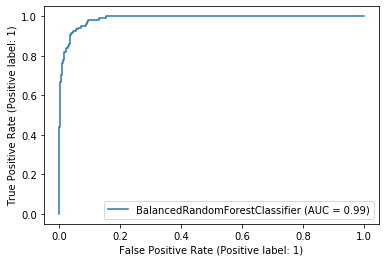

In [43]:
cm2 = confusion_matrix(y_train,y_pred_modelo2)
print(cm2)

#plot_confusion_matrix(rf_1,X_train_adasyn,y_train_adasyn,cmap=plt.cm.Blues)
plot_confusion_matrix(rf_22,X_train_imputed_no_homa,y_train,cmap=plt.cm.Blues)

plt.show()

print('{0,0} True negatives')
print('------')
print('{1,0} False negatives')
print('------')
print('{1,1} True positives')
print('------')
print('{0,1} False positives')
print('------')

accuracy1=(cm2[0,0]+cm2[1,1])/(cm2[0,0]+cm2[1,1]+cm2[0,1]+cm2[1,0])
print ('Accuracy : ', accuracy1)

sensitivity1 = cm2[1,1]/(cm2[1,0]+cm2[1,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm2[0,0]/(cm2[0,0]+cm2[0,1])  #ojo, creo que está al revés esto
print('Specificity : ', specificity1)


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve

plot_roc_curve(rf_22, X_train_imputed_no_homa, y_train)
plt.show()

### Prestaciones en test

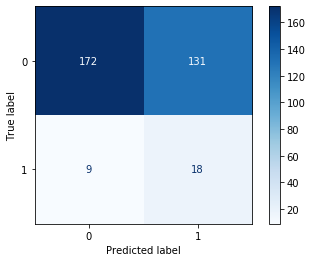

In [45]:
#modify NaNs in X_test

feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']

X_test_modelo2 = pd.DataFrame(X_test[:,0,:],columns = feature_names[:-1])

X_test_modelo2 = X_test_modelo2.drop('Blood_Glucose',axis = 1)
X_test_modelo2 = X_test_modelo2.drop('Glycated-HB',axis = 1)
X_test_modelo2 = X_test_modelo2.drop('HOMA',axis = 1)
X_test_modelo2 = X_test_modelo2.drop('Insulin',axis = 1)
X_test_modelo2 = X_test_modelo2.drop('Vitamin-D',axis = 1)

#impute

#X_test_modelo2 = X_test_modelo2.fillna(X_train_sin_NaN_modelo2.median()) # esto está mal, puede ser que el resultado sea el mismo, lo debería pensar pero el resultado está mal
X_test_modelo2 = X_test_modelo2.fillna(imputation_data_no_homa[0])



y_pred_test_modelo2 = rf_22.predict(X_test_modelo2)
y_pred_test_prob_modelo2 = rf_22.predict_proba(X_test_modelo2) #Probabilidad de pertenecer a cada clase

plot_confusion_matrix(rf_22,X_test_modelo2,y_test,cmap=plt.cm.Blues)

plt.show()

[[172 131]
 [  9  18]]
{0,0} True negatives
------
{1,0} False negatives
------
{1,1} True positives
------
{0,1} False positives
------
Accuracy :  0.5757575757575758
Specificity :  0.5676567656765676
Sensitivity :  0.6666666666666666


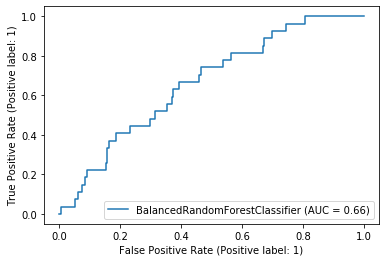

In [46]:
cm3 = confusion_matrix(y_test,y_pred_test_modelo2)

print(cm3)

print('{0,0} True negatives')
print('------')
print('{1,0} False negatives')
print('------')
print('{1,1} True positives')
print('------')
print('{0,1} False positives')
print('------')

accuracy1=(cm3[0,0]+cm3[1,1])/(cm3[0,0]+cm3[1,1]+cm3[0,1]+cm3[1,0])
print ('Accuracy : ', accuracy1)

specificity1 = cm3[0,0]/(cm3[0,0]+cm3[0,1])  #ojo, creo que está al revés esto
print('Specificity : ', specificity1)

sensitivity1 = cm3[1,1]/(cm3[1,0]+cm3[1,1])
print('Sensitivity : ', sensitivity1 )


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve



plot_roc_curve(rf_22, X_test_modelo2,y_test)
plt.show()

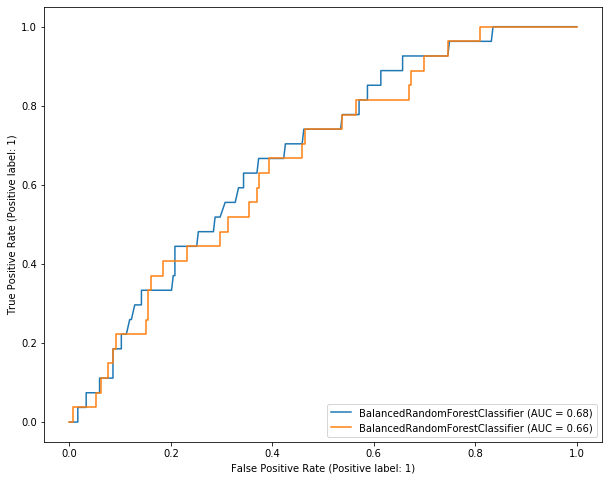

In [47]:
#compare ROC curves

fig, ax = plt.subplots(figsize = (10,8))

plot_roc_curve(rf_2, X_test_modelo1,y_test,ax= ax)
plot_roc_curve(rf_22, X_test_modelo2,y_test,ax = ax)

## Guardamos todas las probabilidades para imputarlas como feature en la segunda revisión

In [48]:
#save decisions

np.save('Dec_train_review_1_all_features', y_pred_modelo1)
np.save('Dec_test_review_1_all_features', y_pred_test_modelo1)
np.save('Dec_train_review_1_without_homa_vit_d', y_pred_modelo2)
np.save('Dec_test_review_1_without_homa_vit_d', y_pred_test_modelo2)


#save probabilities
np.save('Prob_train_review_1_all_features', y_pred_prob_modelo1[:,1])
np.save('Prob_test_review_1_all_features', y_pred_test_prob_modelo1[:,1])
np.save('Prob_train_review_1_without_homa_vit_d', y_pred_1_prob_modelo2[:,1])
np.save('Prob_test_review_1_without_homa_vit_d', y_pred_test_prob_modelo2[:,1])

#save models


#save calibrated probabilities
np.save('Prob_calib_train_review_1_all_features', y_train_cali)
np.save('Prob_calib_test_review_1_all_features', y_pred_cali)